In [1]:

import numpy as np 
import pandas as pd
import time
import datetime
import random

import matplotlib.pyplot as plt

from transformers import BertTokenizer,BertForSequenceClassification, AdamW, BertConfig,get_linear_schedule_with_warmup
from transformers import AutoModel, AutoTokenizer


from keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

######################################


import pandas as pd
path="/kaggle/input/tweets-train-test-nlp"
train2016=pd.read_csv(path+"/tweets_train_2016.csv")
test2016=pd.read_csv(path+"/tweets_test_2016.csv")

train2020=pd.read_csv(path+"/tweets_train_2020.csv")
test2020=pd.read_csv(path+"/tweets_test_2020.csv")

#unicode text
train2016['clean_text']=train2016['clean_text'].values.astype('U')
test2016['clean_text']=test2016['clean_text'].values.astype('U')
train2020['clean_text']=train2020['clean_text'].values.astype('U')
test2020['clean_text']=test2020['clean_text'].values.astype('U')
train2016['text']=train2016['text'].values.astype('U')
test2016['text']=test2016['text'].values.astype('U')
train2020['text']=train2020['text'].values.astype('U')
test2020['text']=test2020['text'].values.astype('U')



/kaggle/input/tweets-train-test-nlp/tweets_test_2016.csv
/kaggle/input/tweets-train-test-nlp/tweets_train_2020.csv
/kaggle/input/tweets-train-test-nlp/tweets_train_2016.csv
/kaggle/input/tweets-train-test-nlp/tweets_test_2020.csv


In [2]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
text = train2016['clean_text'].values
labels = train2016['label'].values

print(text)
print(labels)

['       rt 4   '
 'donald trump is accused of raping a 13-year-old girl. don t you find strange that the media failed to cover it    '
 'clinton rebounds, but we still have to play offense. get out the vote. '
 ...
 'watching  and they 2 idiots to 1 decent person on  always saying if anyone other then  they would be up 10 . go  '
 'the don live  realdonaldtrump  rally hershey pa  rsbnetwork cams plus chat  chock-full of  '
 'its 2016 so its okay for ironic how trump is using the  hashtag because that s a roach burn the place down']
['Democrat' 'Democrat' 'Democrat' ... 'Republican' 'Republican'
 'Republican']


# Utils functions

In [4]:

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# Evaluation function

We will be creating an global evaluation function that takes as an input the name of the model to evaluate and the year of the datas to use and that then fine tune the model and test it on the test datas.

In [5]:
batch_size = 32
epochs = 8

MAX_LEN = 64 #len of the padded sentences

In [11]:
def EvaluateBertModels(model_name="bert-base-uncased",training_year=2016,testing_year=2016,batch_size=batch_size,epochs=epochs,MAX_LEN=MAX_LEN):
    
    if training_year==2016:
        train_set=train2016
    elif training_year==2020:
        train_set=train2020
    else:
        print("No training data for this year : ",str(training_year))
    
    if testing_year==2016:
        test_set=test2016
    elif testing_year==2020:
        test_set=test2020
    else:
        print("No testing data for this year : ",str(testing_year))
       
    text = train_set['clean_text'].values
    labels = train_set['label'].values
    
    print("Loading the Tokenizer")
    if model_name=="bert-base-uncased": #as well as every lower case models that might be used
        lower_case=True
    else:
        lower_case=False
    
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=lower_case)
    
    print("Encoding the sentences")
    
    input_ids = []

    for sent in text:
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent)
        
    print("=============================================")
    print("Example of encoded sentence")
    print('Original: ', text[1])
    print('Tokens: ',tokenizer.convert_ids_to_tokens(input_ids[1]))
    print('Token IDs:', input_ids[1])
    print("=============================================")
    print("\n")

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    
    print("Adding padding to the sentences")
    
    print("=============================================")
    print("Example of padded and encoded sentence")
    print('Token IDs:',input_ids[1])
    print('Tokens',tokenizer.convert_ids_to_tokens(input_ids[1]))    
    print("=============================================")
    print("\n")

    print("Creating attention masks")
    print("=============================================")
    print("Example of attention mask for the previous sentence")
    attention_masks = []
    for sent in input_ids:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)

    print(attention_masks[1])
    print("=============================================")
    print("\n")
    
    print("Splitting the train set into train and validation set (90%/10%)")
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                                random_state=2018, test_size=0.1)
    train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                                 random_state=2018, test_size=0.1)
    
    print("Mapping labels to values")
    mapping={"Democrat":0,"Republican":1}

    train_labels=np.array(pd.Series(train_labels).map(mapping))
    validation_labels=np.array(pd.Series(validation_labels).map(mapping))

    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)    
    
    print("Creating dataloaders for training and validation sets")
    
    # Create the DataLoader for the training set.
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for the validation set.
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    print("Loading the BERT Classifier")
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 2,  output_attentions = False, output_hidden_states = False)
    #model = AutoModel.from_pretrained(model_name, num_labels = 2,  output_attentions = False, output_hidden_states = False)
    model.cuda()
    
    print("Model Structure")
    print("=============================================")

    params = list(model.named_parameters())

    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
        
    print("=============================================")
    print("\n")
    
    print("Loading the AdamW optimizer")
    optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
    
    print("Loading the scheduler for learning rate")
    total_steps = len(train_dataloader) * epochs 

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = total_steps)

    
    
    print("=============================================")
    print("Starting to train the model")
    
    
    loss_values = []
    avg_eval_accuracies=[]

    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_loss = 0
        model.train() #set the model to "train" mode (batchnorm and dropout layers does not act the same for validation)

        for step, batch in enumerate(train_dataloader):

            if step % 5 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device).long()
            b_input_mask = batch[1].to(device).long()
            b_labels = batch[2].to(device).long()

            model.zero_grad()        


            outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            #return the loss and not the output when we provide the labels

            loss = outputs[0]

            total_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            #update the model weights
            optimizer.step()

            #update the learning rate
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)            
        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval() #set the model to evaluation mode

        # Tracking variables 
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device).long()
            b_input_mask = batch[1].to(device).long()
            b_labels = batch[2].to(device).long()

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():        
                outputs = model(b_input_ids, token_type_ids=None,  attention_mask=b_input_mask) #returns the logits values of the prediction because we did not provide the real labels

            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy

            nb_eval_steps += 1

        # Report the final accuracy for this validation run.

        avg_eval_accuracy=eval_accuracy/nb_eval_steps
        avg_eval_accuracies.append(avg_eval_accuracy)

        print("  Accuracy: {0:.2f}".format(avg_eval_accuracy))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Training complete!")    
    print("=============================================")
    print("\n")    
    
    print("Performance on the test set")        
    print("=============================================")
    print("Preprocessing the test set")        

    text = test_set["text"].values
    labels = test_set["label"].values
    labels=np.array(pd.Series(labels).map(mapping))

    input_ids = []

    for sent in text:
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    attention_masks = []

    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    prediction_inputs = torch.tensor(input_ids)
    prediction_masks = torch.tensor(attention_masks)
    prediction_labels = torch.tensor(labels)

    batch_size = 32  

    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    print("Running the model with the test set")        
 
    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
    model.eval()

    predictions , true_labels = [], []

    for batch in prediction_dataloader:
        b_input_ids = batch[0].to(device).long()
        b_input_mask = batch[1].to(device).long()
        b_labels = batch[2].to(device).long()
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    print('DONE.') 
    
    accuracies = []

    print('Calculating accuracies for each batch...')

    for i in range(len(true_labels)):
        pred_labels_i = np.argmax(predictions[i], axis=1).flatten()  
        acc = accuracy_score(true_labels[i], pred_labels_i)                
        accuracies.append(acc)   
        
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    flat_true_labels = [item for sublist in true_labels for item in sublist]

    acc = accuracy_score(flat_true_labels, flat_predictions)
    
    df_acc=pd.DataFrame({"label":flat_true_labels,"prediction":flat_predictions})
    df_acc["accurate"]=(df_acc["label"]==df_acc["prediction"])
    cross_accuracy_stats=pd.crosstab(df_acc["label"],df_acc["accurate"])
    
    print('Global  test accuracy : %.3f' % acc)  
    print("=============================================")
    
    return(acc,cross_accuracy_stats,loss_values,avg_eval_accuracies)

In [12]:
results_bertbase_2016_2016=EvaluateBertModels()

Loading the Tokenizer
Encoding the sentences
Example of encoded sentence
Original:  donald trump is accused of raping a 13-year-old girl. don t you find strange that the media failed to cover it    
Tokens:  ['[CLS]', 'donald', 'trump', 'is', 'accused', 'of', 'rap', '##ing', 'a', '13', '-', 'year', '-', 'old', 'girl', '.', 'don', 't', 'you', 'find', 'strange', 'that', 'the', 'media', 'failed', 'to', 'cover', 'it', '[SEP]']
Token IDs: [101, 6221, 8398, 2003, 5496, 1997, 9680, 2075, 1037, 2410, 1011, 2095, 1011, 2214, 2611, 1012, 2123, 1056, 2017, 2424, 4326, 2008, 1996, 2865, 3478, 2000, 3104, 2009, 102]


Adding padding to the sentences
Example of padded and encoded sentence
Token IDs: [ 101 6221 8398 2003 5496 1997 9680 2075 1037 2410 1011 2095 1011 2214
 2611 1012 2123 1056 2017 2424 4326 2008 1996 2865 3478 2000 3104 2009
  102    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:04.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:22.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

In [14]:
results_bertbase_2020_2020=EvaluateBertModels(model_name="bert-base-uncased",training_year=2020,testing_year=2020)
results_bertbase_2016_2020=EvaluateBertModels(model_name="bert-base-uncased",training_year=2016,testing_year=2020)

results_bertweet_2016_2016=EvaluateBertModels(model_name='vinai/bertweet-base',training_year=2016,testing_year=2016)
results_bertweet_2020_2020=EvaluateBertModels(model_name='vinai/bertweet-base',training_year=2020,testing_year=2020)
results_bertweet_2016_2020=EvaluateBertModels(model_name='vinai/bertweet-base',training_year=2016,testing_year=2020)

Loading the Tokenizer
Encoding the sentences
Example of encoded sentence
Original:  the way 2020 is going, i m currently awaiting the moment rita repulsa pops up and; supersizes trump for his last ditch attempt to claim the swing states..      -     
Tokens:  ['[CLS]', 'the', 'way', '2020', 'is', 'going', ',', 'i', 'm', 'currently', 'awaiting', 'the', 'moment', 'rita', 'rep', '##uls', '##a', 'pops', 'up', 'and', ';', 'super', '##si', '##zes', 'trump', 'for', 'his', 'last', 'ditch', 'attempt', 'to', 'claim', 'the', 'swing', 'states', '.', '.', '-', '[SEP]']
Token IDs: [101, 1996, 2126, 12609, 2003, 2183, 1010, 1045, 1049, 2747, 15497, 1996, 2617, 11620, 16360, 28426, 2050, 16949, 2039, 1998, 1025, 3565, 5332, 11254, 8398, 2005, 2010, 2197, 14033, 3535, 2000, 4366, 1996, 7370, 2163, 1012, 1012, 1011, 102]


Adding padding to the sentences
Example of padded and encoded sentence
Token IDs: [  101  1996  2126 12609  2003  2183  1010  1045  1049  2747 15497  1996
  2617 11620 16360 28426  20

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:05.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:22.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:05.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:22.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Encoding the sentences
Example of encoded sentence
Original:  donald trump is accused of raping a 13-year-old girl. don t you find strange that the media failed to cover it    
Tokens:  ['<s>', 'donald', 'trump', 'is', 'accused', 'of', 'raping', 'a', '13-@@', 'year-old', 'girl@@', '.', 'don', 't', 'you', 'find', 'strange', 'that', 'the', 'media', 'failed', 'to', 'cover', 'it', '</s>']
Token IDs: [0, 21196, 3377, 17, 5963, 15, 24071, 11, 14842, 4705, 9058, 4, 3468, 552, 14, 259, 4390, 25, 6, 919, 2900, 9, 1355, 18, 2]


Adding padding to the sentences
Example of padded and encoded sentence
Token IDs: [    0 21196  3377    17  5963    15 24071    11 14842  4705  9058     4
  3468   552    14   259  4390    25     6   919  2900     9  1355    18
     2     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
To

Downloading:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.embeddings.position_ids', 'roberta.embeddings.word_embeddings.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weigh

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (64001, 768)
bert.embeddings.position_embeddings.weight                (130, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:05.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:21.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Encoding the sentences
Example of encoded sentence
Original:  the way 2020 is going, i m currently awaiting the moment rita repulsa pops up and; supersizes trump for his last ditch attempt to claim the swing states..      -     
Tokens:  ['<s>', 'the', 'way', '2020', 'is', 'going@@', ',', 'i', 'm', 'currently', 'awaiting', 'the', 'moment', 'rita', 'repul@@', 'sa', 'pops', 'up', 'and@@', ';', 'super@@', 'sizes', 'trump', 'for', 'his', 'last', 'ditch', 'attempt', 'to', 'claim', 'the', 'swing', 'stat@@', 'es@@', '..', '-', '</s>']
Token IDs: [0, 6, 154, 3504, 17, 45006, 7, 37, 504, 1691, 22583, 6, 693, 47213, 60171, 1846, 7629, 49, 1429, 208, 4954, 11199, 3377, 19, 91, 175, 13918, 3673, 9, 2309, 6, 7236, 11860, 783, 67, 34, 2]


Adding padding to the sentences
Example of padded and encoded sentence
Token IDs: [    0     6   154  3504    17 45006     7    37   504  1691 22583     6
   693 47213 60171  1846  7629    49  1429   208  4954 11199  3377    19
    91   175 13918  3673     9  2309

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.embeddings.position_ids', 'roberta.embeddings.word_embeddings.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weigh

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (64001, 768)
bert.embeddings.position_embeddings.weight                (130, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:04.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:21.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

Token indices sequence length is longer than the specified maximum sequence length for this model (213 > 128). Running this sequence through the model will result in indexing errors


  Accuracy: 0.67
  Validation took: 0:00:01

Training complete!


Performance on the test set
Preprocessing the test set
Running the model with the test set
Predicting labels for 2,000 test sentences...
DONE.
Calculating accuracies for each batch...
Global  test accuracy : 0.542
Loading the Tokenizer


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Encoding the sentences
Example of encoded sentence
Original:  donald trump is accused of raping a 13-year-old girl. don t you find strange that the media failed to cover it    
Tokens:  ['<s>', 'donald', 'trump', 'is', 'accused', 'of', 'raping', 'a', '13-@@', 'year-old', 'girl@@', '.', 'don', 't', 'you', 'find', 'strange', 'that', 'the', 'media', 'failed', 'to', 'cover', 'it', '</s>']
Token IDs: [0, 21196, 3377, 17, 5963, 15, 24071, 11, 14842, 4705, 9058, 4, 3468, 552, 14, 259, 4390, 25, 6, 919, 2900, 9, 1355, 18, 2]


Adding padding to the sentences
Example of padded and encoded sentence
Token IDs: [    0 21196  3377    17  5963    15 24071    11 14842  4705  9058     4
  3468   552    14   259  4390    25     6   919  2900     9  1355    18
     2     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
To

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertForSequenceClassification: ['roberta.embeddings.position_ids', 'roberta.embeddings.word_embeddings.weight', 'roberta.embeddings.position_embeddings.weight', 'roberta.embeddings.token_type_embeddings.weight', 'roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.key.weight', 'roberta.encoder.layer.0.attention.self.key.bias', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.bias', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.encoder.layer.0.attention.output.dense.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encode

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weigh

Model Structure
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (64001, 768)
bert.embeddings.position_embeddings.weight                (130, 768)
bert.embeddings.token_type_embeddings.weight                (1, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

  Batch    10  of    113.    Elapsed: 0:00:02.
  Batch    15  of    113.    Elapsed: 0:00:03.
  Batch    20  of    113.    Elapsed: 0:00:04.
  Batch    25  of    113.    Elapsed: 0:00:06.
  Batch    30  of    113.    Elapsed: 0:00:07.
  Batch    35  of    113.    Elapsed: 0:00:08.
  Batch    40  of    113.    Elapsed: 0:00:09.
  Batch    45  of    113.    Elapsed: 0:00:10.
  Batch    50  of    113.    Elapsed: 0:00:11.
  Batch    55  of    113.    Elapsed: 0:00:12.
  Batch    60  of    113.    Elapsed: 0:00:14.
  Batch    65  of    113.    Elapsed: 0:00:15.
  Batch    70  of    113.    Elapsed: 0:00:16.
  Batch    75  of    113.    Elapsed: 0:00:17.
  Batch    80  of    113.    Elapsed: 0:00:18.
  Batch    85  of    113.    Elapsed: 0:00:19.
  Batch    90  of    113.    Elapsed: 0:00:20.
  Batch    95  of    113.    Elapsed: 0:00:21.
  Batch   100  of    113.    Elapsed: 0:00:23.
  Batch   105  of    113.    Elapsed: 0:00:24.
  Batch   110  of    113.    Elapsed: 0:00:25.

  Average tr

Token indices sequence length is longer than the specified maximum sequence length for this model (213 > 128). Running this sequence through the model will result in indexing errors


  Accuracy: 0.70
  Validation took: 0:00:01

Training complete!


Performance on the test set
Preprocessing the test set
Running the model with the test set
Predicting labels for 2,000 test sentences...
DONE.
Calculating accuracies for each batch...
Global  test accuracy : 0.605


# Displaying the results

In [43]:
def DrawResults(results,name="Model"):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(range(epochs),results[2])
    plt.title("Model : "+name+"\n Training loss among epochs")
    plt.subplot(122)
    plt.plot(range(epochs),results[3])
    plt.title("Model : "+name+"\n Validation accuracy among epochs \n Global test accuracy : "+str(results[0]))
    
    r_mapping={0:"Democrat",1:"Republican"}

    results[1].index=results[1].index.map(r_mapping)
    results[1]["Accuracy"]=results[1][True]/(results[1][True]+results[1][False])
    print(results[1])


accurate    False  True  Accuracy
label                            
Democrat      362   448  0.553086
Republican    218   972  0.816807


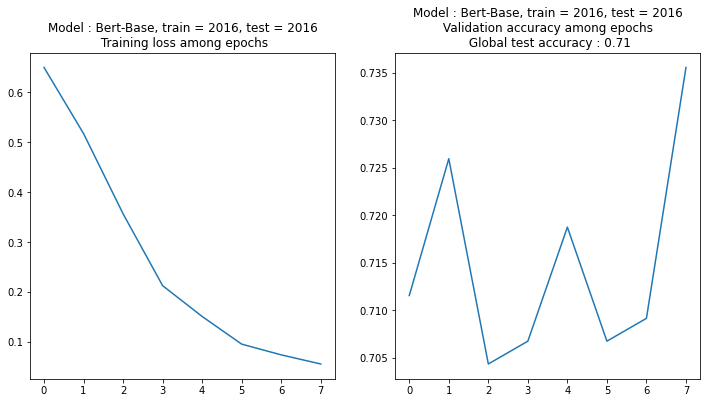

In [45]:
DrawResults(results_bertbase_2016_2016,"Bert-Base, train = 2016, test = 2016")

accurate  False  True  Accuracy
NaN         188   501  0.727141
NaN         520   791  0.603356


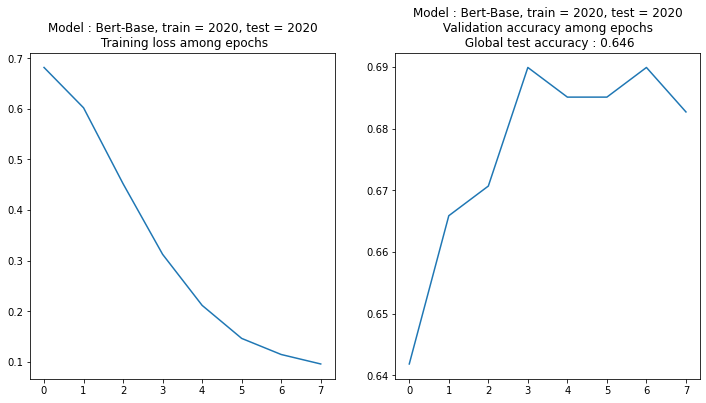

In [46]:
DrawResults(results_bertbase_2020_2020,"Bert-Base, train = 2020, test = 2020")

accurate    False  True  Accuracy
label                            
Democrat      391   298  0.432511
Republican    416   895  0.682685


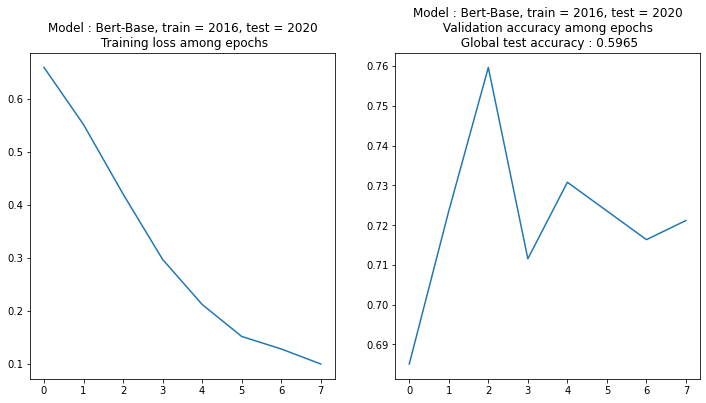

In [47]:
DrawResults(results_bertbase_2016_2020,"Bert-Base, train = 2016, test = 2020")

accurate    False  True  Accuracy
label                            
Democrat      487   323  0.398765
Republican    259   931  0.782353


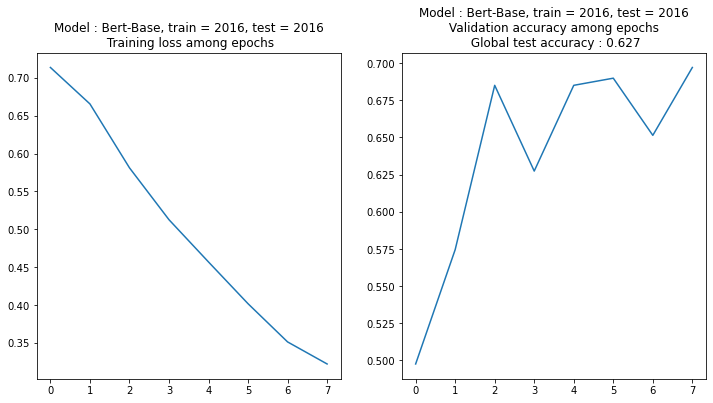

In [48]:
DrawResults(results_bertweet_2016_2016,"Bert-Base, train = 2016, test = 2016")

accurate    False  True  Accuracy
label                            
Democrat      188   501  0.727141
Republican    727   584  0.445461


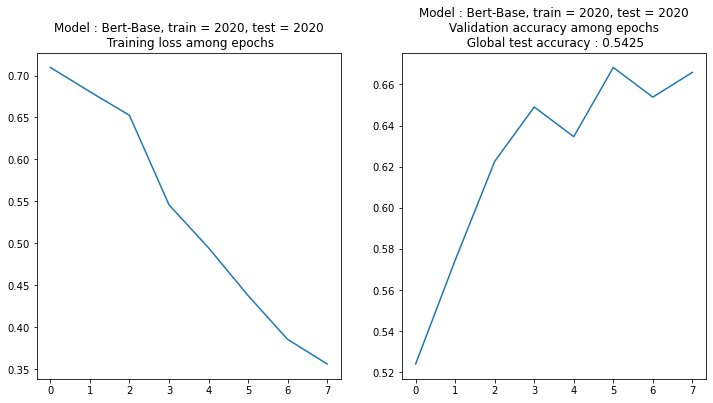

In [49]:
DrawResults(results_bertweet_2020_2020,"Bert-Base, train = 2020, test = 2020")

accurate    False  True  Accuracy
label                            
Democrat      494   195  0.283019
Republican    296  1015  0.774218


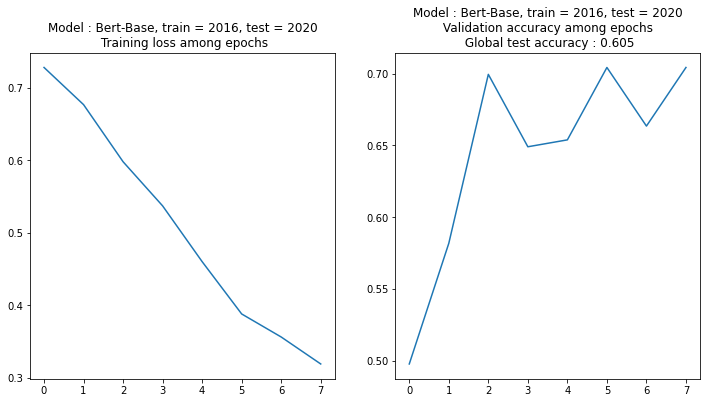

In [50]:
DrawResults(results_bertweet_2016_2020,"Bert-Base, train = 2016, test = 2020")